<a href="https://colab.research.google.com/github/ks-chauhan/radar-activity-recognition/blob/main/notebooks/Baseline_RDM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
## Drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!unzip /content/drive/MyDrive/preprocessed_data.zip -d /content/

Archive:  /content/drive/MyDrive/preprocessed_data.zip
replace /content/preprocessed_data/24GHz/Away/01060010_1573837114.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [17]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

In [18]:
# --- Configurations ---
PROCESSED_DATA_DIR = "preprocessed_data"
RADAR_TYPE = "Xethru"

# Path to save the model to
DATA_SAVE_PATH = "/content/drive/MyDrive/Data_Save_Path"
os.makedirs(DATA_SAVE_PATH, exist_ok = True)

# Model Training Parameters
BATCH_SIZE = 32
IMG_SIZE = 128
VALIDATION_SPLIT = 0.2


In [19]:
# --- Data Preparation ---

# path to the specific radar type directory
radar_data_dir = os.path.join(PROCESSED_DATA_DIR, RADAR_TYPE)
print(f"Loading data from: {radar_data_dir}")

# 1.) Image transformations :-
#  - Resize images to IMG_SIZE
#  - convert to tensor and scaling values from [0, 255] to [0, 1]
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# 2.) Loading the entire dataset using ImageFolder
dataset = datasets.ImageFolder(root = radar_data_dir, transform = transform)
class_names = dataset.classes
print(f"classes found : {class_names}")

Loading data from: preprocessed_data/Xethru
classes found : ['Away', 'Bend', 'Crawl', 'Kneel', 'Limp', 'Pick', 'SStep', 'Scissor', 'Sit', 'Toes', 'Towards']


In [20]:
# 3.) Splitting the dataset into training and validation sets
num_data = len(dataset)
num_val = int(num_data * VALIDATION_SPLIT)
num_train = num_data - num_val

train_dataset, val_dataset = random_split(dataset,
                                          [num_train, num_val],
                                          generator = torch.Generator().manual_seed(42))

print(f"Training samples: {num_train}, Validation samples: {num_val}")

Training samples: 523, Validation samples: 130


In [21]:
# 4.) Creating DataLoaders for both training and validation datasets
train_loader = DataLoader(train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True)

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle = False)

In [22]:
# Data Inspection
images_batch, Labels_batch = next(iter(train_loader))
print(f"Batch size: {images_batch.shape}, Labels: {Labels_batch.shape}")

Batch size: torch.Size([32, 3, 128, 128]), Labels: torch.Size([32])


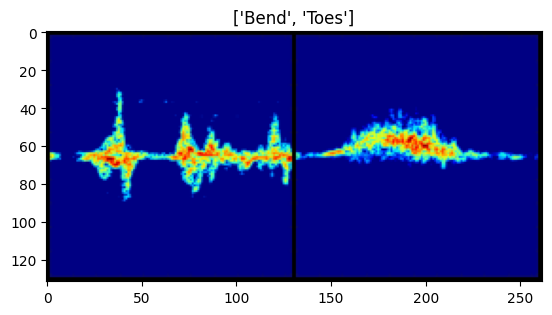

In [23]:
def sample_display(inp, title=None):
    """Display sample images"""
    inp = inp.numpy().transpose((1, 2, 0)) # [C, H, W] to [H, W, C]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# One batch of Training images
images, labels = next(iter(train_loader))

# Displaying the first 9 images in the batch
import torchvision
out = torchvision.utils.make_grid(images[16:18])
sample_display(out, title=[class_names[x] for x in labels[16:18]])
plt.show()

In [24]:
## ---- MODEL DEFINITION ----
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Input shape : [batch, 3, 128, 128]
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        # Output shape : [batch, 16, 128, 128]
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # Output Shape : [batch, 16, 64, 64]

        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        # Output Shape : [batch, 32, 64, 64]
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # Output Shape : [batch, 32, 32, 32]

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        # Output Shape : [batch, 64, 32, 32]
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # Output Shape : [batch, 64, 16, 16]

        # Flatten the output from the convolutional layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*16*16, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x


In [25]:
## Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device : {device}")

Using Device : cuda


In [26]:
## Instantiating the model
model = SimpleCNN(num_classes = len(class_names)).to(device)

In [29]:
import time
## ---- Training the Model ----
print("Starting Model Training")

# Loss function and optimizer definition
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

start_time = time.time()
best_val_accuracy = 0.0
best_val_loss = 100.0
NUM_EPOCHS = 15 # Number of epochs for training
for epoch in range(NUM_EPOCHS):
    model.train() # Setting the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i,(images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        prediction = model(images)
        loss = criterion(prediction, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(prediction.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    epoch_loss = running_loss / total_samples
    epoch_accuracy = (correct_predictions / total_samples) * 100

    # --- Validation step ---
    model.eval() # Setting the model to envaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            prediction = model(val_images)
            loss = criterion(prediction, val_labels)

            val_loss += loss.item() * val_images.size(0)
            _, val_predicted = torch.max(prediction.data, 1)
            val_total_samples += val_labels.size(0)
            val_correct_predictions += (val_predicted == val_labels).sum().item()
        val_epoch_loss = val_loss / val_total_samples
        val_epoch_accuracy = (val_correct_predictions / val_total_samples) * 100

        print(f"epoch [{epoch+1}/{NUM_EPOCHS}] | ")
        print(f"training loss : {epoch_loss:.4f} and training accuracy : {epoch_accuracy:.2f}% | ")
        print(f"validation loss : {val_epoch_loss:.4f} and validation accuracy : {val_epoch_accuracy:.2f}% | ")
        if (val_epoch_accuracy > best_val_accuracy and val_epoch_loss < best_val_loss):
            best_val_accuracy = val_epoch_accuracy
            best_val_loss = val_epoch_loss
            model_name = f"best_model_{RADAR_TYPE}.pth"
            torch.save(model.state_dict(), os.path.join(DATA_SAVE_PATH, model_name))
            print(f"-> New best model saved with accuracy: {val_epoch_accuracy:.2f}%")

end_time = time.time()
print("\n Training completed")
print(f"total time take : {end_time - start_time:.2f} seconds")

Starting Model Training
epoch [1/15] | 
training loss : 1.0007 and training accuracy : 61.76% | 
validation loss : 0.8264 and validation accuracy : 66.92% | 
-> New best model saved with accuracy: 66.92%
epoch [2/15] | 
training loss : 0.6611 and training accuracy : 71.51% | 
validation loss : 0.7171 and validation accuracy : 76.15% | 
-> New best model saved with accuracy: 76.15%
epoch [3/15] | 
training loss : 0.5013 and training accuracy : 82.03% | 
validation loss : 0.6382 and validation accuracy : 73.08% | 
epoch [4/15] | 
training loss : 0.4378 and training accuracy : 83.17% | 
validation loss : 0.5418 and validation accuracy : 79.23% | 
-> New best model saved with accuracy: 79.23%
epoch [5/15] | 
training loss : 0.3948 and training accuracy : 87.00% | 
validation loss : 0.7071 and validation accuracy : 74.62% | 
epoch [6/15] | 
training loss : 0.3155 and training accuracy : 88.91% | 
validation loss : 0.6346 and validation accuracy : 76.15% | 
epoch [7/15] | 
training loss : 0.